In [84]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA

In [85]:
# Load dataset
dataset_path = '/content/top5_leagues_player.csv'
data = pd.read_csv(dataset_path)

In [63]:
# Menampilkan informasi awal tentang dataset
print("Info Dataset:")
print(data.info())
print("\nSample Data:")
print(data.head())

Info Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2612 entries, 0 to 2611
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        2612 non-null   int64  
 1   name              2612 non-null   object 
 2   full_name         1480 non-null   object 
 3   age               2612 non-null   int64  
 4   height            2601 non-null   float64
 5   nationality       2612 non-null   object 
 6   place_of_birth    2595 non-null   object 
 7   price             2602 non-null   float64
 8   max_price         2606 non-null   float64
 9   position          2612 non-null   object 
 10  shirt_nr          2612 non-null   int64  
 11  foot              2576 non-null   object 
 12  club              2612 non-null   object 
 13  contract_expires  2544 non-null   object 
 14  joined_club       2612 non-null   object 
 15  player_agent      2353 non-null   object 
 16  outfitter         1003 non-n

In [86]:
# Data Cleaning and Preprocessing
# 1. Handle Missing Values:
for col in ['price', 'max_price', 'age', 'height']:
    # Impute with median for numerical features
    data[col] = pd.to_numeric(data[col], errors='coerce')
    median_val = data[col].median()
    data[col].fillna(median_val, inplace=True)

<ipython-input-86-c9a4276b848a>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(median_val, inplace=True)


In [87]:
# 2. Feature Engineering (if necessary):  Create new features if they can improve clustering.
# For example:  Price difference between max price and current price
data['price_diff'] = data['max_price'] - data['price']

In [81]:
data.columns

Index(['Unnamed: 0', 'name', 'full_name', 'age', 'height', 'nationality',
       'place_of_birth', 'price', 'max_price', 'position', 'shirt_nr', 'foot',
       'club', 'contract_expires', 'joined_club', 'player_agent', 'outfitter',
       'league'],
      dtype='object')

In [82]:
# Bersihkan nilai string dari kolom numerik (jika ada)
numeric_columns = ['price', 'max_price', 'name', 'full_name', 'age', 'height',
                   'nationality', 'place_of_birth', 'position', 'shirt_nr', 'foot', 'club', 'contract_expires', 'joined_club', 'player_agent', 'outfitter',
       'league']
for col in numeric_columns:
    if col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')

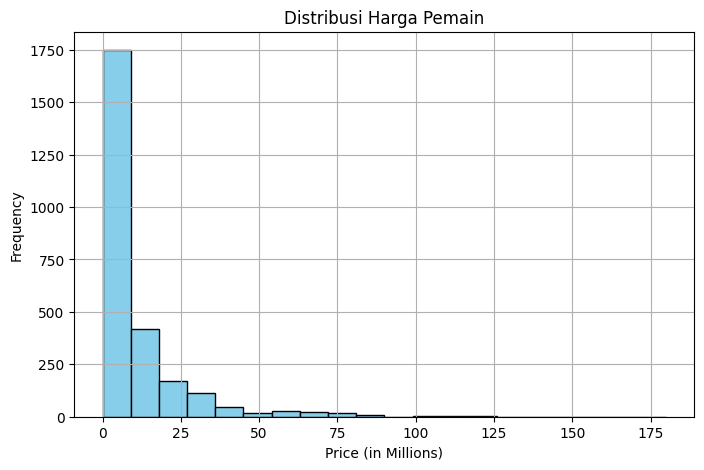

In [65]:
# Eksplorasi Data Awal
# Distribusi Harga Pemain
plt.figure(figsize=(8, 5))
data['price'].hist(bins=20, color='skyblue', edgecolor='black')
plt.title('Distribusi Harga Pemain')
plt.xlabel('Price (in Millions)')
plt.ylabel('Frequency')
plt.show()

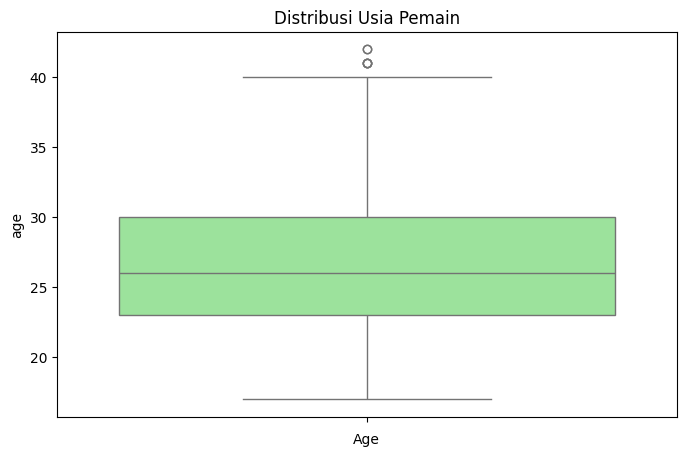

In [66]:
# Boxplot Usia Pemain
plt.figure(figsize=(8, 5))
sns.boxplot(data['age'], color='lightgreen')
plt.title('Distribusi Usia Pemain')
plt.xlabel('Age')
plt.show()

In [67]:
print(data.columns)

Index(['Unnamed: 0', 'name', 'full_name', 'age', 'height', 'nationality',
       'place_of_birth', 'price', 'max_price', 'position', 'shirt_nr', 'foot',
       'club', 'contract_expires', 'joined_club', 'player_agent', 'outfitter',
       'league'],
      dtype='object')


In [91]:
# 3. Feature Selection
features = data[['price', 'max_price', 'age', 'height', 'price_diff']] # Include engineered features
labels = data['max_price']

In [90]:
# Use SelectKBest if target is available, otherwise use PCA
try:
    selector = SelectKBest(score_func=f_regression, k=3)
    features_selected = selector.fit_transform(features, labels)
    selected_columns = features.columns[selector.get_support()]
    print("Fitur Terpilih:", selected_columns)
    features = features[selected_columns]
except ValueError:
    print("'max_price' not found for feature selection, using PCA")
    pca = PCA(n_components=3) # Reduce to 3 components
    features = pca.fit_transform(features)

Fitur Terpilih: Index(['price', 'age', 'price_diff'], dtype='object')


In [70]:
# Menangani nilai kosong (jika ada)
features = features.dropna()
labels = labels.loc[features.index]

In [92]:
# Normalisasi data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [93]:
# Menentukan jumlah cluster menggunakan Elbow Method
inertia = []
silhouette_scores = []
k_range = range(2, 11)  # Start k from 2

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # Increased n_init for better results
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(features_scaled, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

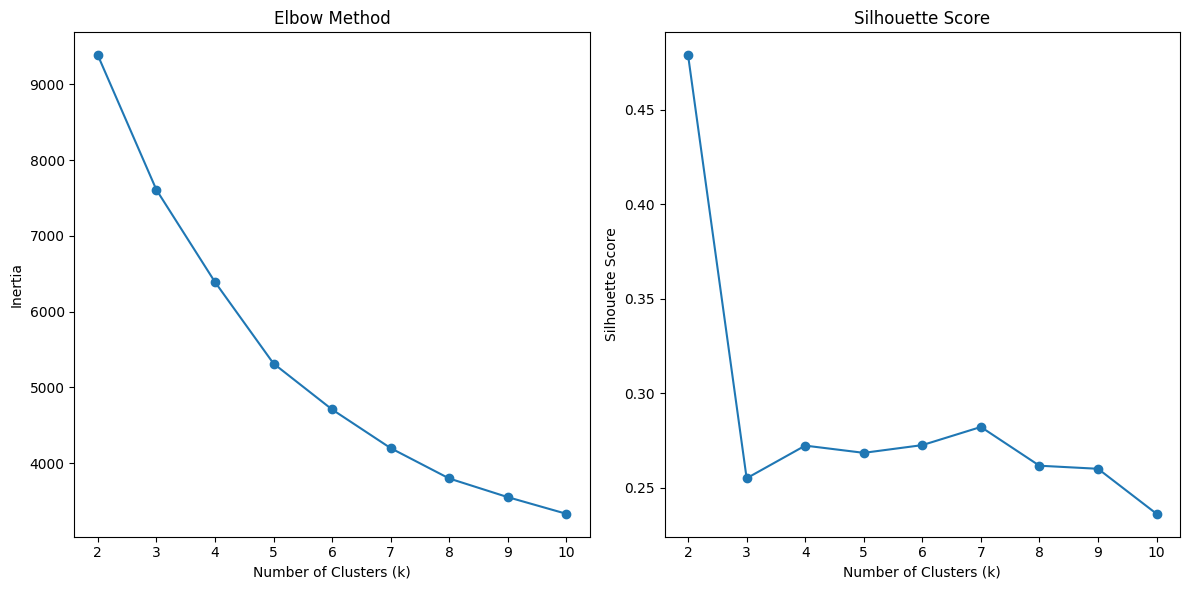

In [95]:
# Visualisasi Elbow Method
plt.figure(figsize=(12, 6))

plt.subplot(1,2,1)
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')

plt.subplot(1,2,2)
plt.plot(k_range, silhouette_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

In [96]:
# Membuat model K-Means dengan jumlah cluster optimal
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"Optimal k from silhouette: {optimal_k}")

Optimal k from silhouette: 2


In [97]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans.fit(features_scaled)

KMeans(n_clusters=2, n_init=10, random_state=42)

In [98]:
# Menambahkan hasil clustering ke dataset
data['Cluster'] = kmeans.labels_

In [99]:
# Evaluasi Clustering dengan Silhouette Score
silhouette_avg = silhouette_score(features_scaled, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.478817186747848


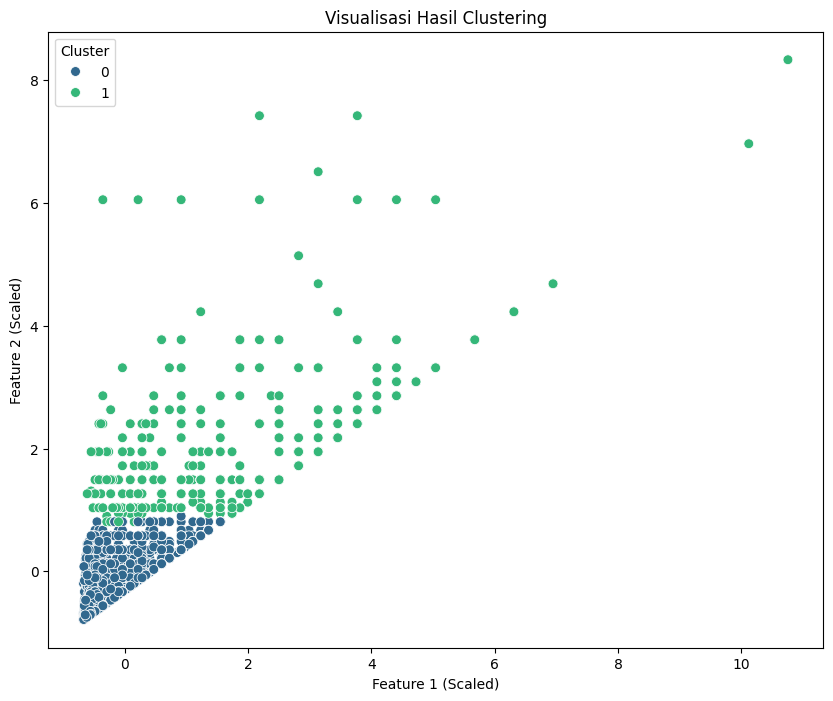

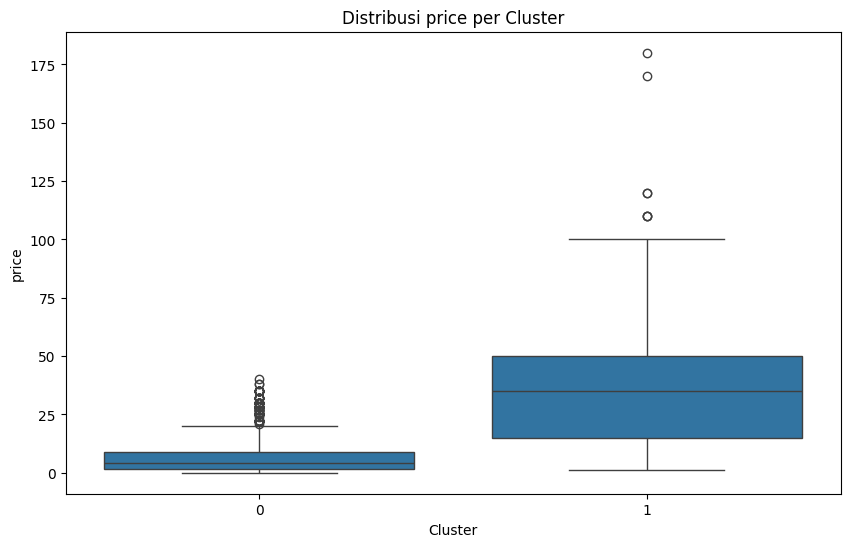

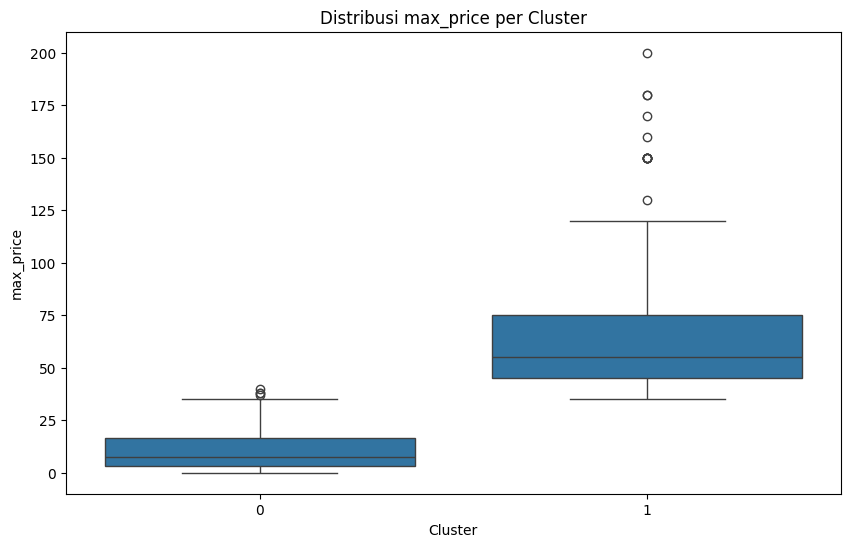

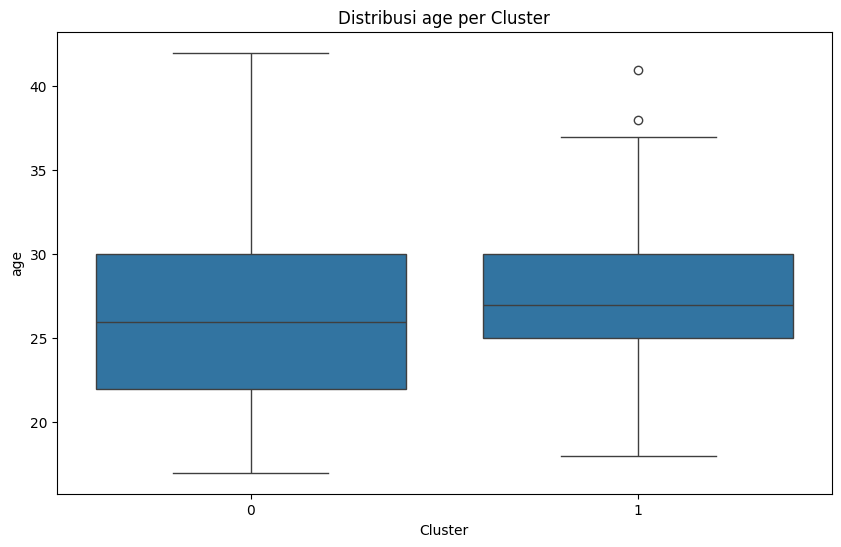

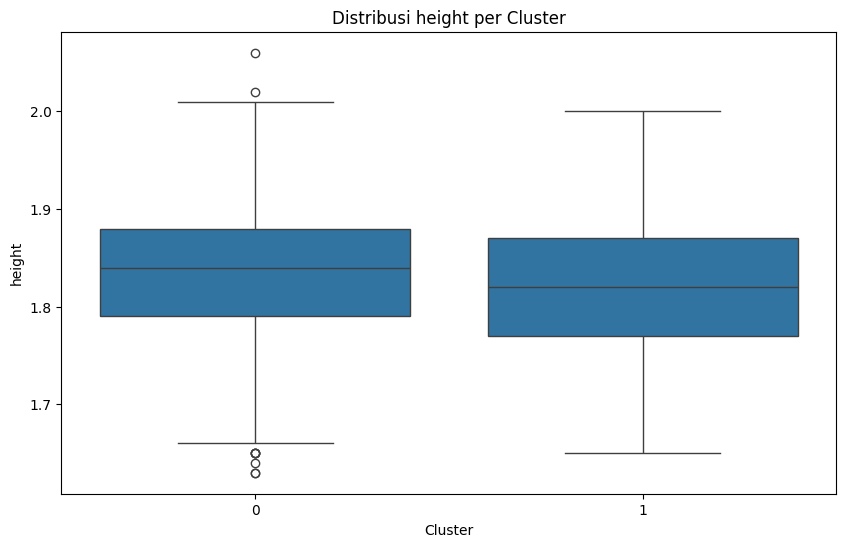

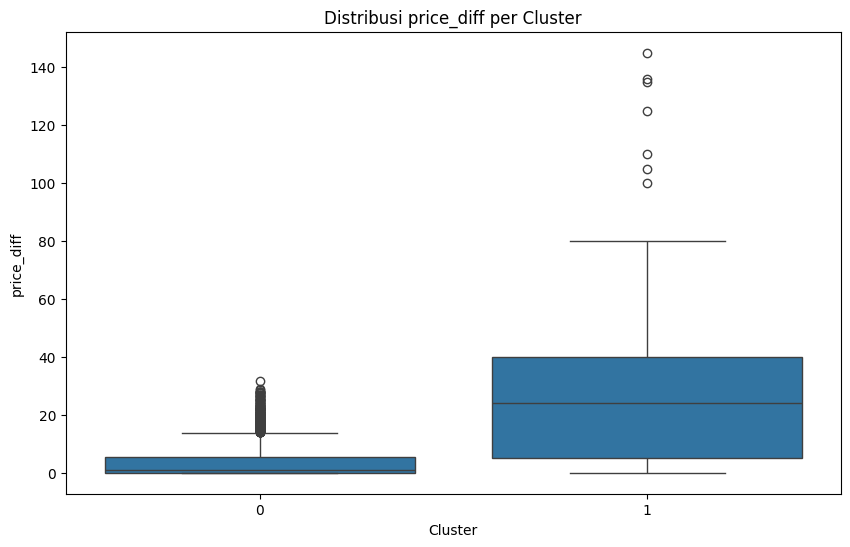

In [101]:
# prompt: # Visualisasi hasil clustering

# Visualisasi hasil clustering
plt.figure(figsize=(10, 8))
sns.scatterplot(x=features_scaled[:, 0], y=features_scaled[:, 1], hue=data['Cluster'], palette='viridis', s=50) # Adjust feature indices if necessary
plt.title('Visualisasi Hasil Clustering')
plt.xlabel('Feature 1 (Scaled)')
plt.ylabel('Feature 2 (Scaled)')
plt.show()

# Visualisasi distribusi fitur pada setiap cluster
for column in features.columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Cluster', y=column, data=data)
    plt.title(f'Distribusi {column} per Cluster')
    plt.show()

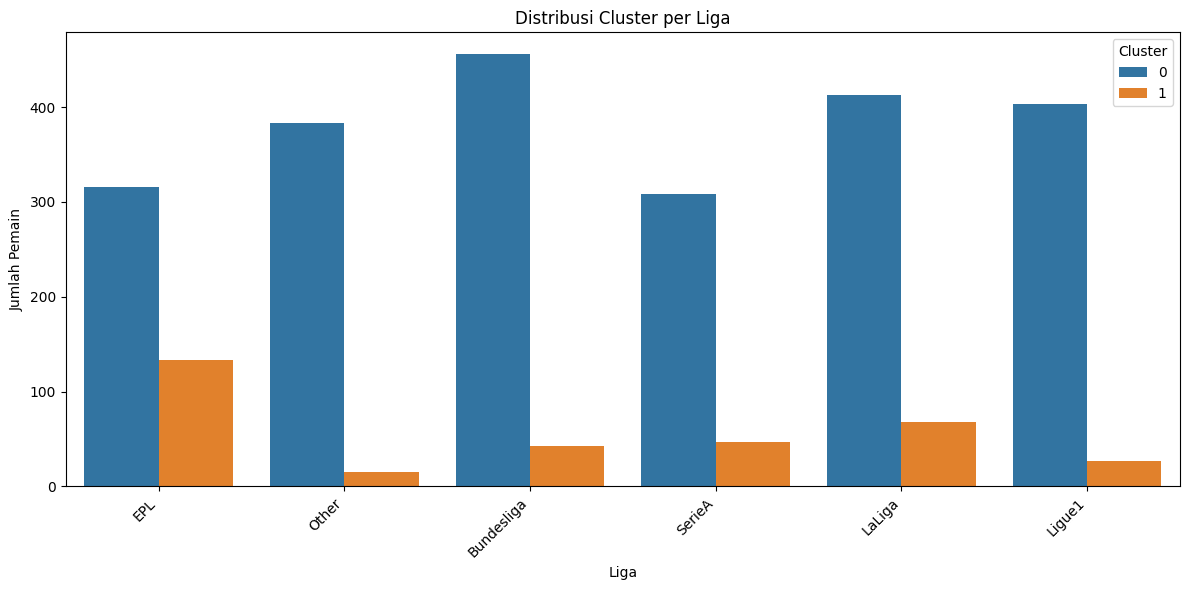

mean  median  count
Cluster league                              
0       Bundesliga   5.431086     3.0    456
        EPL         12.736076    12.0    316
        LaLiga       5.934383     3.5    413
        Ligue1       6.093672     4.0    403
        Other        4.671932     2.0    383
        SerieA       6.934984     4.0    308
1       Bundesliga  43.220930    40.0     43
        EPL         40.804511    38.0    133
        LaLiga      34.036765    30.0     68
        Ligue1      36.833333    30.0     27
        Other       35.166667    28.0     15
        SerieA      27.723404    18.0     47

In [103]:
# Analisis distribusi cluster berdasarkan liga
plt.figure(figsize=(12, 6))
sns.countplot(x='league', hue='Cluster', data=data)
plt.title('Distribusi Cluster per Liga')
plt.xlabel('Liga')
plt.ylabel('Jumlah Pemain')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

# Analisis lebih lanjut: Statistik deskriptif per cluster dan liga
cluster_league_stats = data.groupby(['Cluster', 'league'])['price'].agg(['mean', 'median', 'count'])
cluster_league_stats

In [104]:
# Analisis lebih lanjut: Statistik deskriptif per cluster dan liga
cluster_league_stats = data.groupby(['Cluster', 'league'])['price'].agg(['mean', 'median', 'count'])
cluster_league_stats

mean  median  count
Cluster league                              
0       Bundesliga   5.431086     3.0    456
        EPL         12.736076    12.0    316
        LaLiga       5.934383     3.5    413
        Ligue1       6.093672     4.0    403
        Other        4.671932     2.0    383
        SerieA       6.934984     4.0    308
1       Bundesliga  43.220930    40.0     43
        EPL         40.804511    38.0    133
        LaLiga      34.036765    30.0     68
        Ligue1      36.833333    30.0     27
        Other       35.166667    28.0     15
        SerieA      27.723404    18.0     47

In [105]:
# Menyimpan hasil clustering ke file CSV
output_path = '/content/clustering_results.csv'
features.to_csv(output_path, index=False)
print(f"Hasil clustering disimpan di {output_path}")

Hasil clustering disimpan di /content/clustering_results.csv
